# Joint Source-Channel Coding using Autoencoders

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* joint compression and error protection of images by auto-encoders
* transmission of pseudo-analog values over an AWGN channel

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

Import and load MNIST dataset

In [2]:
mnist = tf.keras.datasets.mnist

# only load the images, we are not interested in the training data
(x_train, _),(x_test, _) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

image_size = x_train.shape[1]

x_test_flat = np.array([np.reshape(x_test[k,:,:], image_size*image_size) for k in range(x_test.shape[0])])

Print 8 random images to illustrate the dataset

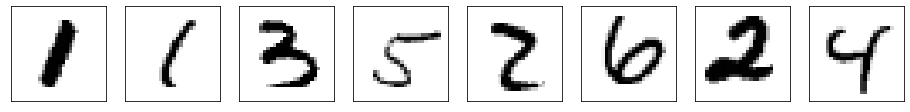

In [3]:
plt.figure(figsize=(16,2))
for k in range(8):
    plt.subplot(1,8,k+1)
    plt.imshow(x_train[np.random.randint(x_train.shape[0])], interpolation='nearest', cmap='binary')
    plt.xticks(())
    plt.yticks(())

Specify neural network. Transmitter and receiver consist of each 3 hidden layers with ELU activation function

In [4]:
# Network parameters
hidden_encoder_1 = 500
hidden_encoder_2 = 250
hidden_encoder_3 = 100

hidden_decoder_1 = 100
hidden_decoder_2 = 250
hidden_decoder_3 = 500

tf.reset_default_graph()

channel_uses = tf.placeholder(tf.int32, shape=())
sigma_n = tf.placeholder(tf.float32, shape=())
training_data = tf.placeholder(tf.float32, [None, image_size*image_size])

valid_data = tf.constant(x_test_flat, dtype=tf.float32)


weights = { 'We1' : tf.Variable(tf.truncated_normal([image_size*image_size, hidden_encoder_1], stddev=0.1)),
            'We2' : tf.Variable(tf.truncated_normal([hidden_encoder_1, hidden_encoder_2], stddev=0.1)),
            'We3' : tf.Variable(tf.truncated_normal([hidden_encoder_2, hidden_encoder_3], stddev=0.1)),
            'We4' : tf.Variable(tf.truncated_normal([hidden_encoder_3, 2*channel_uses], stddev=0.1), validate_shape=False),
            'Wd1' : tf.Variable(tf.truncated_normal([2*channel_uses, hidden_decoder_1], stddev=0.1), validate_shape=False),
            'Wd2' : tf.Variable(tf.truncated_normal([hidden_decoder_1, hidden_decoder_2], stddev=0.1)),
            'Wd3' : tf.Variable(tf.truncated_normal([hidden_decoder_2, hidden_decoder_3], stddev=0.1)),
            'Wd4' : tf.Variable(tf.truncated_normal([hidden_decoder_3, image_size*image_size], stddev=0.1)),
          }

biases = {  'be1' : tf.Variable(tf.truncated_normal([hidden_encoder_1], stddev=0.1)),
            'be2' : tf.Variable(tf.truncated_normal([hidden_encoder_2], stddev=0.1)),
            'be3' : tf.Variable(tf.truncated_normal([hidden_encoder_3], stddev=0.1)),
            'be4' : tf.Variable(tf.truncated_normal([2*channel_uses], stddev=0.1), validate_shape=False),
            'bd1' : tf.Variable(tf.truncated_normal([hidden_decoder_1], stddev=0.1)),
            'bd2' : tf.Variable(tf.truncated_normal([hidden_decoder_2], stddev=0.1)),
            'bd3' : tf.Variable(tf.truncated_normal([hidden_decoder_3], stddev=0.1)),
            'bd4' : tf.Variable(tf.truncated_normal([image_size*image_size], stddev=0.1)),
          }

def encoder(batch):
    temp = tf.nn.elu(tf.matmul(batch, weights['We1']) + biases['be1'])
    temp = tf.nn.elu(tf.matmul(temp, weights['We2']) + biases['be2'])
    temp = tf.nn.elu(tf.matmul(temp, weights['We3']) + biases['be3'])
    output = tf.matmul(temp, weights['We4']) + biases['be4']
    return output

def channel(batch):
    norm_factor = tf.sqrt(tf.reduce_mean(tf.square(batch)) * 2 )                            
    modulated = batch / norm_factor 
    output = modulated + sigma_n * tf.random.normal(tf.shape(modulated))
    return output

def decoder(batch):
    temp = tf.nn.elu(tf.matmul(batch, weights['Wd1']) + biases['bd1'])
    temp = tf.nn.elu(tf.matmul(temp, weights['Wd2']) + biases['bd2'])
    temp = tf.nn.elu(tf.matmul(temp, weights['Wd3']) + biases['bd3'])
    output = tf.nn.sigmoid(tf.matmul(temp, weights['Wd4']) + biases['bd4'])
    return output

compressed = encoder(training_data)
transmitted = channel(compressed)
reconstructed = decoder(transmitted)

compressed_test = encoder(valid_data)
transmitted_test = channel(compressed_test)
reconstructed_test = decoder(transmitted_test)

loss_test = tf.reduce_mean(tf.square(valid_data - reconstructed_test))

loss = tf.losses.mean_squared_error(training_data, reconstructed)
train_step = tf.train.AdamOptimizer().minimize(loss)


init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


Helper function to get a random batch of images from the dataset

In [5]:
def get_batch(x, batch_size):
    idxs = np.random.randint(0, x.shape[0], (batch_size))
    return np.array([np.reshape(x[k,:,:], image_size*image_size) for k in idxs])

Perform the training

In [6]:
batch_size = 250

EsN0 = 30


# Create session and initialize all variables
session = tf.InteractiveSession()
session.run(init, feed_dict = {sigma_n : np.sqrt((1/2) * 10**(-EsN0/10)), channel_uses : 5})

# Training loop
for it in range(25000):  # Original paper does 50k iterations  
    mini_batch = get_batch(x_train, batch_size)
    feed_dict = {
        training_data : mini_batch,
        sigma_n : np.sqrt((1/2) * 10**(-EsN0/10)),
        channel_uses : 20
    }
    
    session.run(train_step, feed_dict = feed_dict)    

    
    if it % 1000 == 0:
        print('It %d: Loss %1.5f' % (it, loss_test.eval(feed_dict = {sigma_n : np.sqrt((1/2) * 10**(-EsN0/10)), channel_uses : 5})))

It 0: Loss 0.22631
It 1000: Loss 0.01906
It 2000: Loss 0.01568
It 3000: Loss 0.01426
It 4000: Loss 0.01332
It 5000: Loss 0.01280
It 6000: Loss 0.01234
It 7000: Loss 0.01208
It 8000: Loss 0.01179
It 9000: Loss 0.01164
It 10000: Loss 0.01149
It 11000: Loss 0.01138
It 12000: Loss 0.01141
It 13000: Loss 0.01115
It 14000: Loss 0.01107
It 15000: Loss 0.01104
It 16000: Loss 0.01095
It 17000: Loss 0.01090
It 18000: Loss 0.01091
It 19000: Loss 0.01083
It 20000: Loss 0.01079
It 21000: Loss 0.01085
It 22000: Loss 0.01077
It 23000: Loss 0.01074
It 24000: Loss 0.01069


Illustrate 8 images and their reconstruction after transmission over the channel

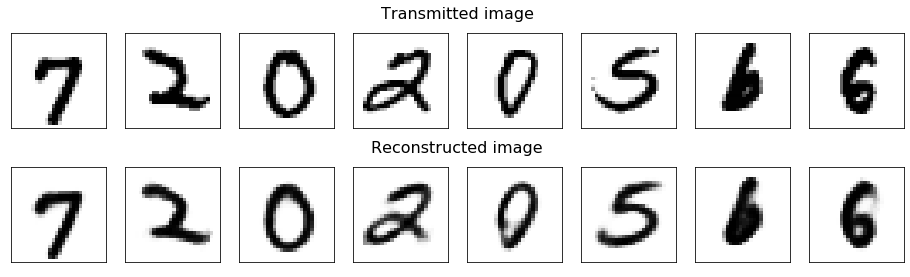

In [7]:
valid_images =  reconstructed_test.eval(feed_dict = {sigma_n : np.sqrt((1/2) * 10**(-EsN0/10)), channel_uses : 5})
# show 8 images and their reconstructed versions


fig,big_ax = plt.subplots(2,1,figsize=(16,4.5), sharey=True)        
big_ax[0].set_title("Transmitted image", fontsize=16)
big_ax[1].set_title("Reconstructed image", fontsize=16)

for k in range(2):
    big_ax[k].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax[k]._frameon = False
    big_ax[k].set_xticks(())
    big_ax[k].set_yticks(())
            
idx = np.random.randint(x_test.shape[0], size=8)       
r_idx = 1
for k in range(8):
    ax = fig.add_subplot(2,8,r_idx)     
    ax.imshow(np.reshape(x_test_flat[idx[k]], (image_size,image_size)), interpolation='nearest', cmap='binary')    
    ax.set_xticks(())
    ax.set_yticks(())
    r_idx += 1
    
for k in range(8):
    ax = fig.add_subplot(2,8,r_idx)    
    ax.imshow(np.reshape(valid_images[idx[k]], (image_size,image_size)), interpolation='nearest', cmap='binary')    
    ax.set_xticks(())
    ax.set_yticks(())
    r_idx +=1 
#plt.savefig('Autoencoder_AWGN_Analog_Esn030.pdf',bbox_inches='tight')

(10000, 10)


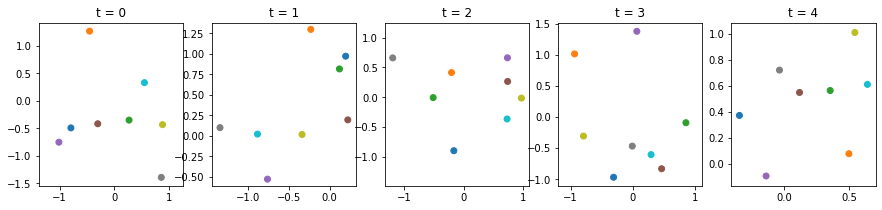

In [8]:
# display received constellations
transmitted = transmitted_test.eval(feed_dict = {sigma_n : np.sqrt((1/2) * 10**(-EsN0/10)), channel_uses : 5})
print(transmitted.shape)
plt.figure(figsize=(15,3))
for k in range(5):
    plt.subplot(1,5,k+1)
    plt.scatter(transmitted[idx,2*k], transmitted[idx,2*k+1],c=range(8),cmap='tab10')
    plt.title('t = %d' % k)
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.axis('equal')
#plt.savefig('Autoencoder_AWGN_Analog_Esn030_scatter8points.pdf',bbox_inches='tight')

(10000, 10)


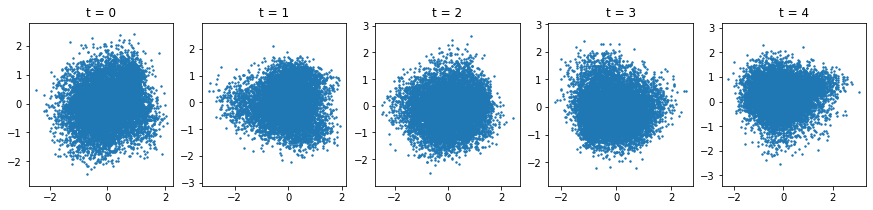

In [9]:
# display received constellations
transmitted = transmitted_test.eval(feed_dict = {sigma_n : np.sqrt((1/2) * 10**(-EsN0/10)), channel_uses : 5})
print(transmitted.shape)
plt.figure(figsize=(15,3))
for k in range(5):
    plt.subplot(1,5,k+1)
    plt.scatter(transmitted[:,2*k], transmitted[:,2*k+1],s=2)
    plt.title('t = %d' % k)
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.axis('equal')
#plt.savefig('Autoencoder_AWGN_Analog_Esn030_scatterallpoints.pdf',bbox_inches='tight')

In [10]:
session.close()